In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst
import conf as cf

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


In [2]:
# date au format 2023_03_28
def read_df(date :str):
    df = pd.read_csv("C:/Users/Olivier/greta/projet_julien/MeteoVelib/data/datasets/stations_statusV2_"+date+".zip")
    df['time'] = pd.to_datetime(df['time'])
    df = df.drop(["Unnamed: 0"] , axis=1)

    return df

In [3]:
df0=read_df("2023_03_18")
df1=read_df("2023_03_19")
df2=read_df("2023_03_20")
df3=read_df("2023_03_21")
df4=read_df("2023_03_22")
df5=read_df("2023_03_23")
df6=read_df("2023_03_24")
df7=read_df("2023_03_25")
df8=read_df("2023_03_26")
df9=read_df("2023_03_27")
df10=read_df("2023_03_28")

In [94]:
df_tot=pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

In [4]:
df0.head()

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,stationCode,name,lon,lat,altitude,capacity,strike,demonstration,occupation_prct,occupation_class
0,213688169,1,0,1,34,1,1,1,1679092047,2023-03-18 00:00:53,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,2.857143,0
1,213688169,1,0,1,34,1,1,1,1679092047,2023-03-18 00:16:55,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,2.857143,0
2,213688169,2,1,1,33,1,1,1,1679095761,2023-03-18 00:32:55,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,5.714286,1
3,213688169,2,1,1,33,1,1,1,1679095761,2023-03-18 00:48:56,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,5.714286,1
4,213688169,3,2,1,32,1,1,1,1679095761,2023-03-18 01:00:57,...,16107,Benjamin Godard - Victor Hugo,2.275725,48.865983,52.619041,35,0,1,8.571429,1


# Correction en 2 parties

On a fait l'hypothèse que les données sont cycliques avec des variations dues à divers facteurs. 
On peut penser que ces facteurs auraient un effet similaires pour différentes stations, et donc refaire une prédiction sur une seule station pour avoir la partie cyclique, et ensuite regarder l'effet sur toutes les stations des autres facteurs sur la différence.

Plan de l'algorithme : 
 - se limiter à juste un jour (j2) et celui de la semaine précédente (j1)
 - faire une prédiction à partir de j1 pour avoir j2_pred (j'utiliserai directement j1)
 - regarder j2-j2_pred (j'utiliserai j2-j1)
 - tracer en fonction de paramètres à déterminer

In [5]:
def get_difference(df1, df2):

    df1['time']=df1['time']+datetime.timedelta(days=7)
    
#     df2=pd.merge_asof(df2, df1, on='time')
    
    
    df_out=pd.merge_asof(df2.sort_values('time'), df1[['time', 'station_id', 'occupation_prct']].sort_values('time'), 
                             on='time', by='station_id', suffixes=('', '_prev'), direction='nearest')
    
    df_out['occupation_diff']=df_out['occupation_prct']-df_out['occupation_prct_prev']
    
    return df_out

In [6]:
# Ajout de valeurs d'occupation 6h plus tot :

def add_old_values(df, df_old=None):
    dec1=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    dec2=6*3+24*3 #on a une valeur toutes les 20 minutes, et on regarde 6+24 heures avant


    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
    df_main["occupation_diff"]=df_main["occupation_prct"].shift(periods=dec1, axis=0)-df_main["occupation_prct"].shift(periods=dec2, axis=0)

   
    df_main=df_main[df_main['jour'] == df['jour'].median()]
    
    
    return df_main

In [7]:
# train : df2 df9
# test :  df3 df10

In [8]:
df2=read_df("2023_03_20")
df3=read_df("2023_03_21")
df9=read_df("2023_03_27")
df10=read_df("2023_03_28")

df_train=get_difference(df2, df9)
df_test=get_difference(df3, df10)


In [9]:
# foo.head()

In [10]:
df_train.dtypes


station_id                           int64
num_bikes_available                  int64
num_bikes_available_mech             int64
num_bikes_available_elec             int64
num_docks_available                  int64
is_installed                         int64
is_returning                         int64
is_renting                           int64
last_reported                        int64
time                        datetime64[ns]
weekday                              int64
year                                 int64
month                                int64
day                                  int64
hour                                 int64
minute                               int64
weather                             object
temperature                        float64
humidity                             int64
visibility                           int64
wind_speed                         float64
wind_deg                             int64
clouds                               int64
stationCode

In [11]:
feat=['station_id','lon', 'lat', 'altitude', 'day', 'weekday', 'hour', 'minute', 'temperature', 'humidity']
target=['occupation_diff']
both=['station_id','lon', 'lat', 'altitude', 'day', 'weekday', 'hour', 'minute', 'temperature', 'humidity', 'occupation_diff']

foo=df_train[both].dropna()
x_train=foo[feat]
y_train=foo[target]

foo=df_test[both].dropna()
x_test=foo[feat]
y_test=foo[target]

# x_train=df_train[feat]
# x_test=df_test[feat]
# y_train=df_train[target]
# y_test=df_test[target]

In [12]:
import seaborn as sns

<AxesSubplot:xlabel='humidity', ylabel='occupation_diff'>

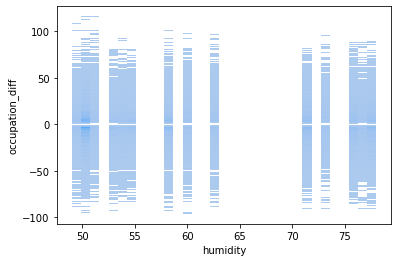

In [13]:
sns.histplot(x='humidity', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='hour', ylabel='occupation_diff'>

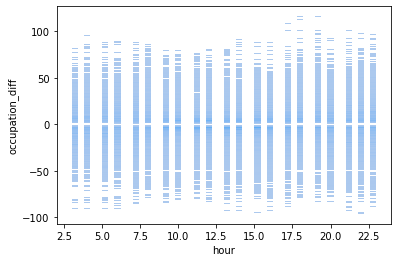

In [14]:
sns.histplot(x='hour', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='lat', ylabel='occupation_diff'>

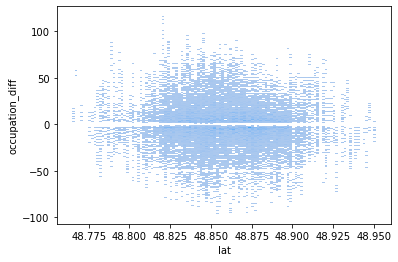

In [15]:
sns.histplot(x='lat', y='occupation_diff', data=df_train)

<AxesSubplot:xlabel='lon', ylabel='occupation_diff'>

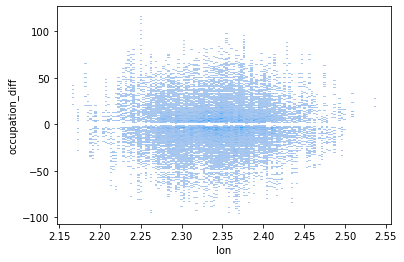

In [16]:
sns.histplot(x='lon', y='occupation_diff', data=df_train)

In [17]:
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error

In [18]:
clf = GradientBoostingRegressor(random_state=0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

MAE: 14.97
MSE: 448.606


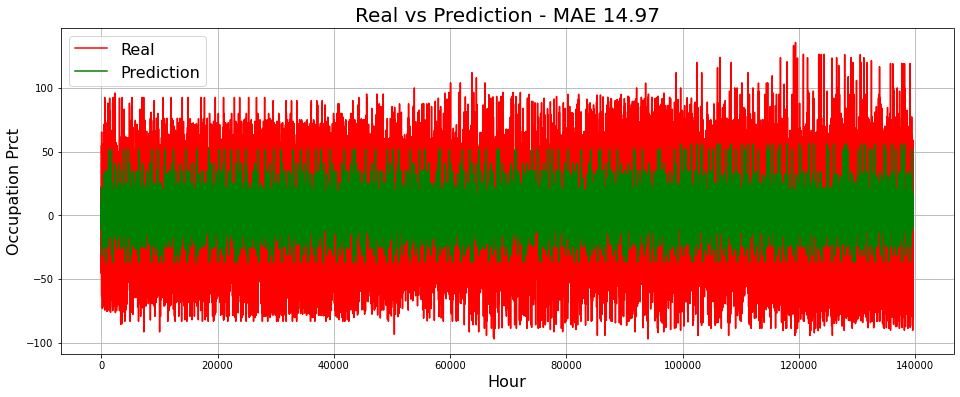

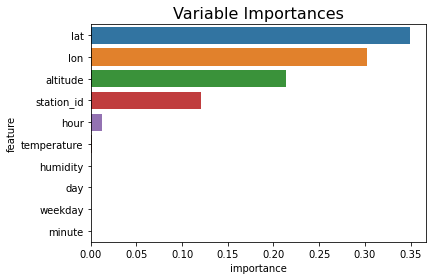

In [46]:
# def plot_error(x_train0, y_train0, y_test0, y_pred0) :

# #     ind=x_train0['station_error'] == station_info[]

mae = np.round(mean_absolute_error(y_test, y_pred), 3)
mse = np.round(mean_squared_error(y_test, y_pred), 3)


print("MAE:", mae)
print("MSE:", mse)

#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(y_pred, index = y_test.index), color='green')

plt.xlabel('Hour', fontsize = 16)
plt.ylabel('Occupation Prct', fontsize = 16)
plt.legend(labels=['Real', 'Prediction', 'Last week'], fontsize = 16)


plt.grid()
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': clf.feature_names_in_,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
plt.show()

In [90]:
#y train, test, et pred : j2-j1
#y test_base : j2
#y pred_base : ~j1
def plot_error(x_train, y_train, y_test, y_pred, y_test_base, y_pred_base) :

# #     


    mae = np.round(mean_absolute_error(y_test, y_pred), 3)
    mse = np.round(mean_squared_error(y_test, y_pred), 3)


    print("MAE:", mae)
    print("MSE:", mse)

    #plot reality vs prediction 
    #figure de différence
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='green')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction'], fontsize = 16)

    plt.grid()
    plt.show()

    #figure totale
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test_base, color='red')
    plt.plot(pd.Series(y_pred+y_pred_base, index = y_test.index), color='green')
    plt.plot(pd.Series(y_pred_base, index = y_test.index), color='blue')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction','Old prediction'], fontsize = 16)

    plt.grid()
    plt.show()
    
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf.feature_names_in_,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()

In [91]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

MAE: 8.954
MSE: 103.349


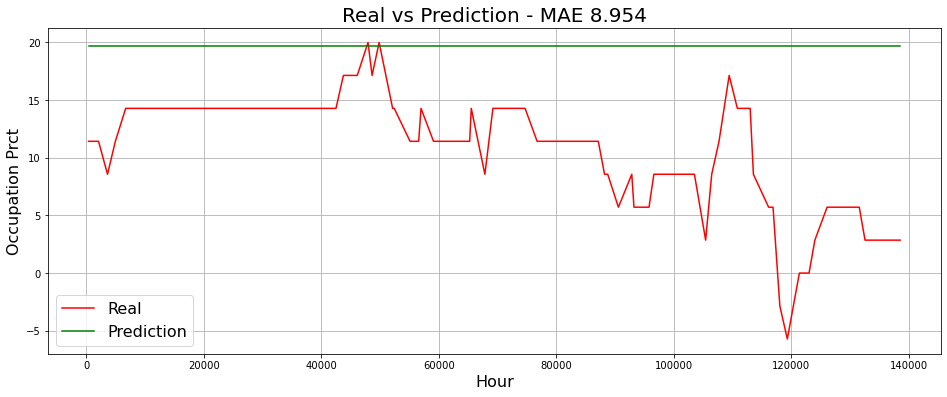

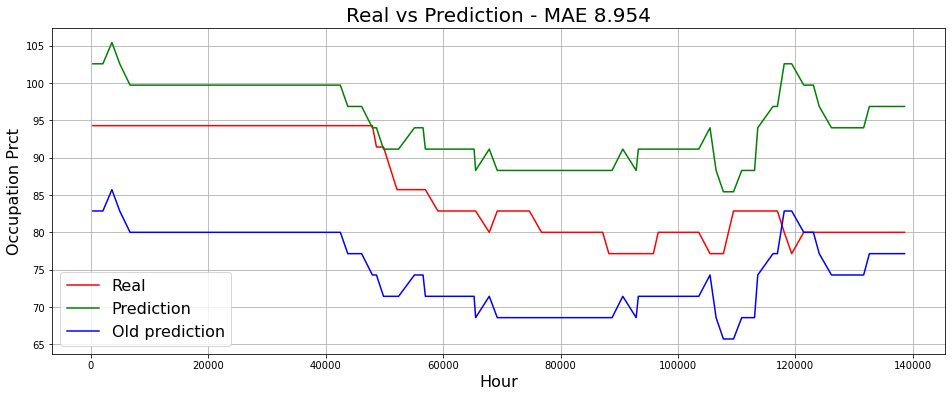

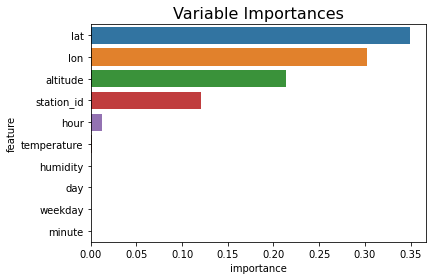

In [92]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 12.239
MSE: 269.718


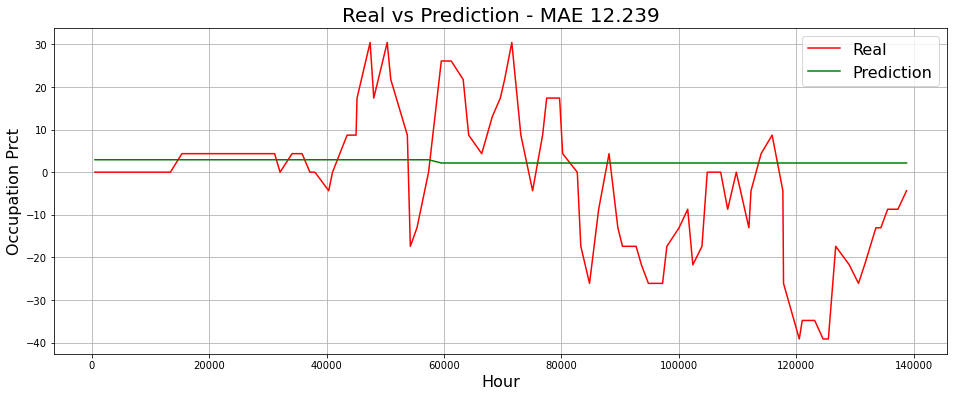

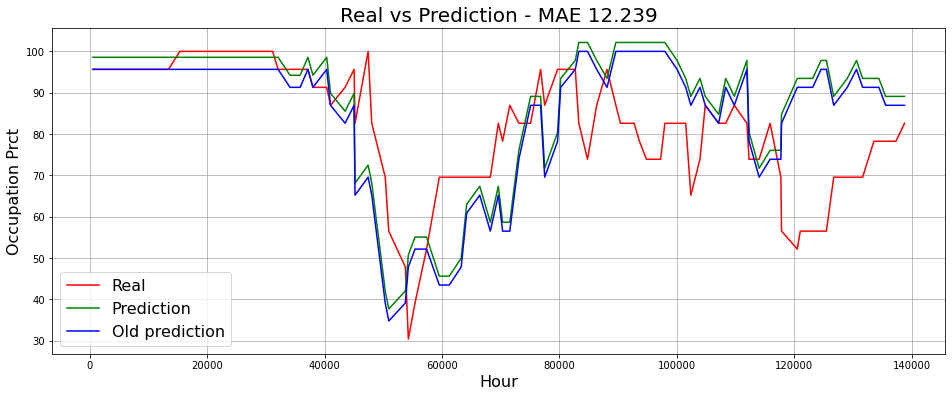

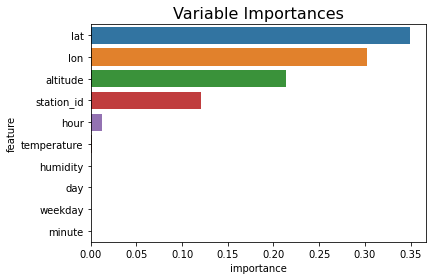

In [93]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 9.091
MSE: 155.304


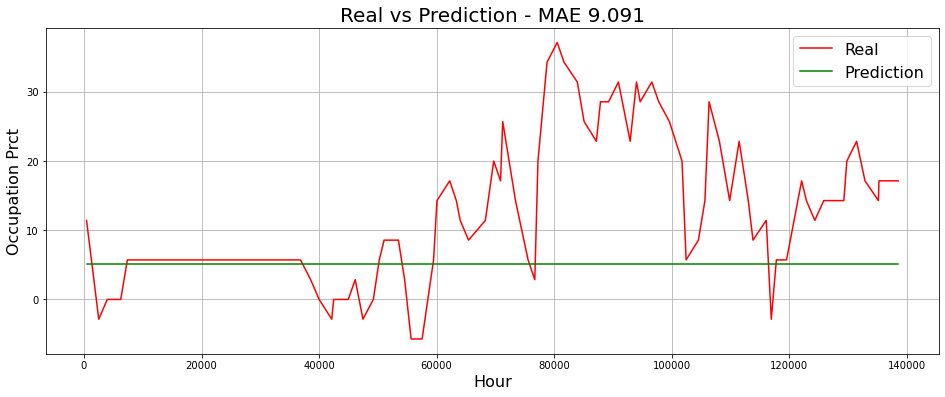

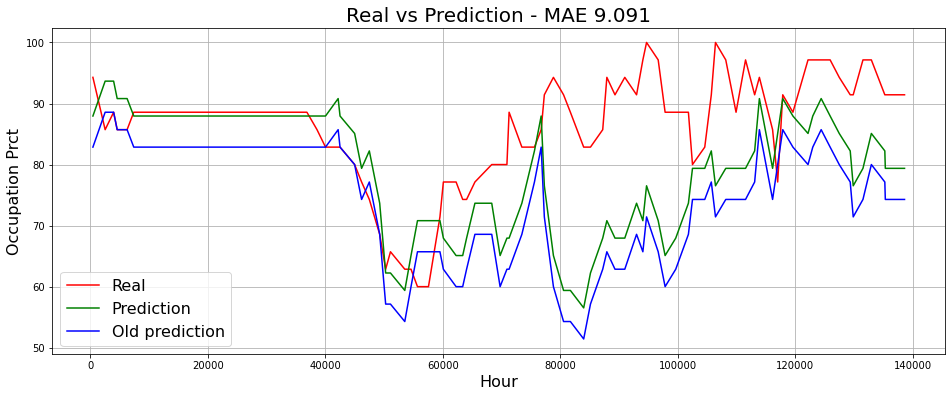

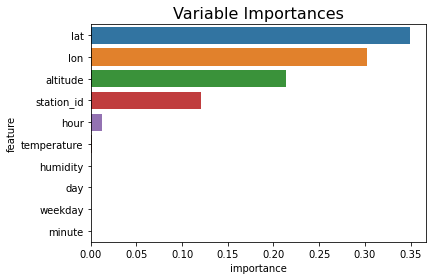

In [103]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


MAE: 21.327
MSE: 727.569


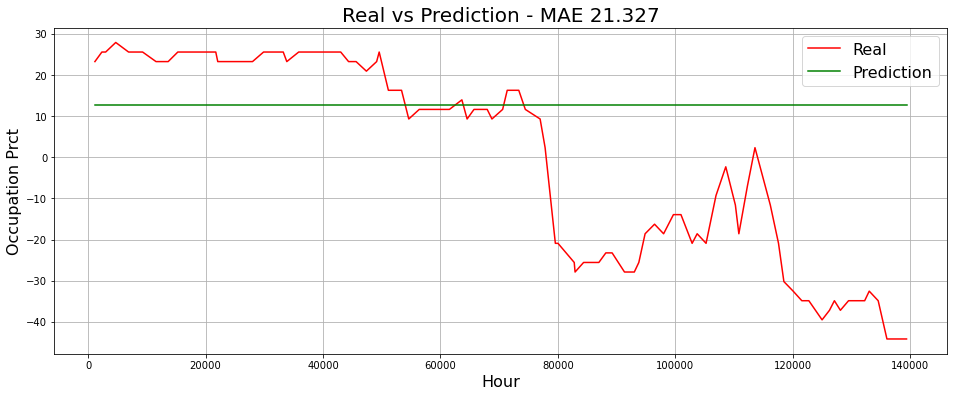

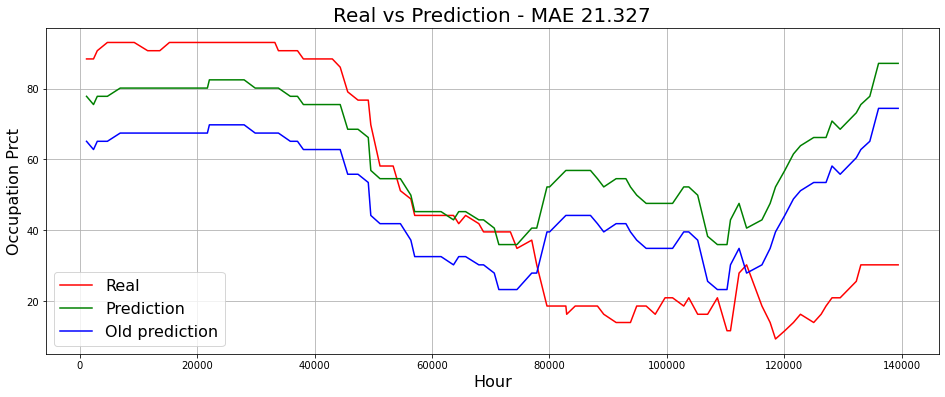

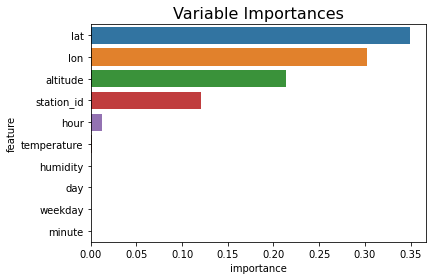

In [104]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df_train_mono=df_train[df_train['station_id'] == station]
df_test_mono=df_test[df_test['station_id'] == station]

# df_train_mono[feat].shape, df_train_mono[target].shape, df_test_mono[target].shape, clf.predict(df_test_mono[feat]).shape

# clf_base= GradientBoostingRegressor(random_state=0)
# feat0=['day', 'weekday', 'hour','minute']
# clf_base.fit(df_train_mono[feat0], df_train_mono[target].values.ravel())
# y_pred_base=clf_base.predict(df_test_mono[feat0])
y_pred_base=df_test_mono['occupation_prct_prev']

plot_error(df_train_mono[feat], df_train_mono[target], df_test_mono[target], clf.predict(df_test_mono[feat]), df_test_mono['occupation_prct'], y_pred_base)


In [ ]:
df_train[df_train['station_id'] == station]

# Autre approche : ajout de l'écart quelques heures avant

In [21]:
#On suppose qu'on a déja 
def add_old_difference(df1, df2):

    df1['time']=df1['time']+datetime.timedelta(days=7)
    
#     df2=pd.merge_asof(df2, df1, on='time')
    
    
    df_out=pd.merge_asof(df2.sort_values('time'), df1[['time', 'station_id', 'occupation_prct']].sort_values('time'), 
                             on='time', by='station_id', suffixes=('', '_prev'), direction='nearest')
    
    df_out['occupation_diff']=df_out['occupation_prct']-df_out['occupation_prct_prev']
    
    return df_out

In [100]:

# Charger le DataFrame contenant les données
def use_old_values(df):

    df['jour']=
    
    # Ajouter des colonnes pour les valeurs précédentes
    for i in range(1, 4):
        df[f'occupation_prct_t-{i}'] = df['occupation_prct'].shift(i)

    # Ajouter une colonne pour la moyenne des valeurs précédentes
    df['occupation_prct_mean'] = df[['occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3']].mean(axis=1)

    # Supprimer les premières lignes qui contiennent des valeurs manquantes dues au décalage
    df = df.dropna()

    # Utiliser les nouvelles colonnes comme features pour le modèle
    features = ['day', 'hour', 'weekday', 'minute', 'humidity', 'wind_speed', 'occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3', 'occupation_prct_mean']

    # Diviser le DataFrame en données d'entraînement et de test
    train = df.loc[df['jour'] <= '2023-03-26']
    test = df.loc[df['jour'] >= '2023-03-27']

    # Créer les matrices X_train, y_train, X_test, y_test pour l'entraînement et la validation
    X_train = train[features]
    y_train = train['occupation_prct']
    X_test = test[features]
    y_test = test['occupation_prct']
    
    
    clf.fit(x_train, y_train.values.ravel())
    y_pred=clf.predict(x_test)
    
    
    mae = np.round(mean_absolute_error(y_test, y_pred), 3)
    mse = np.round(mean_squared_error(y_test, y_pred), 3)

    #plot reality vs prediction 

    #figure totale
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='green')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='blue')

    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction','Old prediction'], fontsize = 16)

    plt.grid()
    plt.show()
    
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf.feature_names_in_,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
    
    

In [101]:
# station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df = df_tot.copy()
df=df[df['station_id'] == station]

use_old_values(df)




TypeError: Invalid comparison between dtype=int64 and str

In [97]:
df.columns

Index(['station_id', 'num_bikes_available', 'num_bikes_available_mech',
       'num_bikes_available_elec', 'num_docks_available', 'is_installed',
       'is_returning', 'is_renting', 'last_reported', 'time', 'weekday',
       'year', 'month', 'day', 'hour', 'minute', 'weather', 'temperature',
       'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds',
       'stationCode', 'name', 'lon', 'lat', 'altitude', 'capacity', 'strike',
       'demonstration', 'occupation_prct', 'occupation_class',
       'occupation_prct_t-1', 'occupation_prct_t-2', 'occupation_prct_t-3',
       'occupation_prct_mean'],
      dtype='object')

In [102]:
df.head()

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,altitude,capacity,strike,demonstration,occupation_prct,occupation_class,occupation_prct_t-1,occupation_prct_t-2,occupation_prct_t-3,occupation_prct_mean
54048,1023083417,8,7.0,1.0,11,1,1,1,1679092106,2023-03-18 00:00:53,...,43.305122,20,0,1,40.0,2,NaN,NaN,NaN,NaN
54049,1023083417,8,7.0,1.0,11,1,1,1,1679092106,2023-03-18 00:16:55,...,43.305122,20,0,1,40.0,2,40.0,NaN,NaN,40.0
54050,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 00:32:55,...,43.305122,20,0,1,40.0,2,40.0,40.0,NaN,40.0
54051,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 00:48:56,...,43.305122,20,0,1,40.0,2,40.0,40.0,40.0,40.0
54052,1023083417,8,7.0,1.0,11,1,1,1,1679095632,2023-03-18 01:00:57,...,43.305122,20,0,1,40.0,2,40.0,40.0,40.0,40.0


# Retour sur la classification des stations

In [22]:
df=df3
# df=df[df['is_renting'] != 1]


In [23]:
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])


In [24]:
for i in range(len(station_list)) :
    station_timeserie[i,:]=df[df['station_id'] == station_list[i]].occupation_prct
    
pd_timeserie=pd.DataFrame(columns=station_list)
for i in range(Nst) :
    pd_timeserie[station_list[i]]=station_timeserie[i,:]

In [25]:
co=pd_timeserie.corr()

<AxesSubplot:>

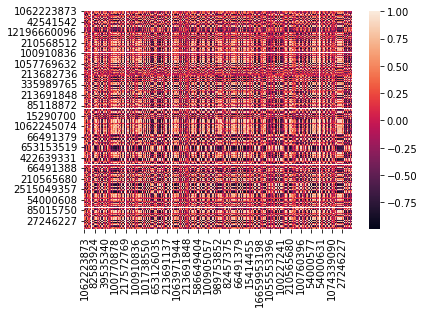

In [26]:
sns.heatmap(co)

In [27]:
pd_timeserie2=pd_timeserie.copy()
col=pd_timeserie2.columns.values
col_sorted=[x for _, x in sorted(zip(co.sum().values, col))]
# col_sorted=pd_timeserie2.columns.values
# col_sorted

In [28]:
pd_timeserie2 = pd_timeserie2.reindex(columns=col_sorted)
co2=pd_timeserie2.corr()

<AxesSubplot:>

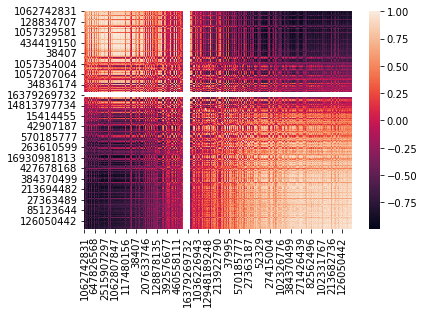

In [29]:
sns.heatmap(co2)


In [37]:
#On va classer les colonnes en fonction de leur corrélation avec une des stations qui correspond à 1 des 2 gros blocs

stat_id_left='102807847'
array_co=co2.to_numpy()


In [38]:
array_co

array([[ 1.        ,  0.81912149,  0.87467122, ..., -0.86675343,
        -0.91114015, -0.89052681],
       [ 0.81912149,  1.        ,  0.75344202, ..., -0.82697373,
        -0.81980338, -0.79027858],
       [ 0.87467122,  0.75344202,  1.        , ..., -0.82671824,
        -0.87265906, -0.83229614],
       ...,
       [-0.86675343, -0.82697373, -0.82671824, ...,  1.        ,
         0.9657246 ,  0.91355511],
       [-0.91114015, -0.81980338, -0.87265906, ...,  0.9657246 ,
         1.        ,  0.9356115 ],
       [-0.89052681, -0.79027858, -0.83229614, ...,  0.91355511,
         0.9356115 ,  1.        ]])

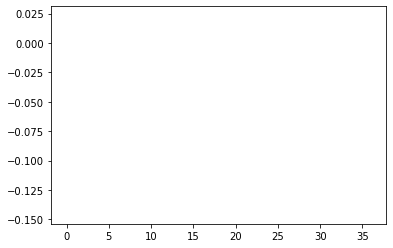

In [31]:
plt.plot(co2.iloc[0,537:574].values)

In [32]:
print(co2.iloc[0,:].values)

[ 1.          0.81912149  0.87467122 ... -0.86675343 -0.91114015
 -0.89052681]


In [33]:
co2.iloc[0,538:573].index

Int64Index([   35196898,    54000624,    76199110,   100905057,   129093478,
              213691137,   213691542,   213699079,   213702608,   213936755,
              213952930,   237041013,   266052390,   335989765,   402212574,
              653139063,  1015246367,  1064008882,  1074339090,  2705290225,
            13568870765, 16043282800, 16379269732, 16816575934, 16898865154,
            16899518505, 17018170219, 17174675707, 17174681330, 17225721242,
            17225742003, 17261310217, 17278902806, 17364417797, 17364714962],
           dtype='int64')

In [34]:
co2.iloc[538:573,0].index

Int64Index([   35196898,    54000624,    76199110,   100905057,   129093478,
              213691137,   213691542,   213699079,   213702608,   213936755,
              213952930,   237041013,   266052390,   335989765,   402212574,
              653139063,  1015246367,  1064008882,  1074339090,  2705290225,
            13568870765, 16043282800, 16379269732, 16816575934, 16898865154,
            16899518505, 17018170219, 17174675707, 17174681330, 17225721242,
            17225742003, 17261310217, 17278902806, 17364417797, 17364714962],
           dtype='int64')

In [35]:
df[df['station_id'].isin(co2.iloc[0,538:573].index)].is_renting

384       0
385       0
386       0
387       0
388       0
         ..
135835    0
135836    0
135837    0
135838    0
135839    0
Name: is_renting, Length: 3360, dtype: int64